In [5]:
len(skin_types)

26

In [475]:
import sys
sys.path += ["/Users/yousuf/Workspace/dissertation/code/rPPG/python/core/"]
import helper
import pandas as pd
PATH = "/Users/yousuf/Workspace/dissertation/code/rPPG/output/hr_evaluation/"
eval_path = "/Users/yousuf/Workspace/dissertation/report/evaluation/"

In [445]:
import scipy.signal
def fft(data, framerate):
    transform = np.fft.rfft(data)
    freqs = np.fft.rfftfreq(len(data), 1.0/framerate)   
    freqs = 60*freqs
    band_pass = np.where((freqs < 40) | (freqs > 240) )[0]
    transform[band_pass] = 0
    transform = np.abs(transform)**2
    sos = scipy.signal.butter(3, 0.2, output='sos')
#     transform = scipy.signal.sosfilt(sos, transform)
    powers = np.argsort(-1*transform)
    return freqs, transform

## Relationship between error and noise

In [644]:
ds = np.array([data["ICA 1 HR"], data["ICA 2 HR"], data["ICA 3 HR"]])
np.std(ds, axis=0).shape

(3414,)

In [743]:
# data = pd.read_csv(PATH + "sp_output_16_03_20.csv")
data = pd.read_csv(PATH + "sp_output_19_03_20.csv")
print(data.columns)
str_cols = ["Video", "Tracker", "Region selector"]
num_cols = [c for c in data.columns if c not in str_cols]
for c in num_cols:
    data[c] = pd.to_numeric(data[c], errors='coerce')
# data["Error"] = np.abs(data["rPPG HR MV"]-data["ECG HR BC"])
data["Error"] = np.abs(data["rPPG HR ICA"]-data["ECG HR BC"])
data["P Error"] = data["Error"]/data["ECG HR BC"]
data["RMSE"] = data["Error"]**2
# data["Error"] = data["Error"]/data["ECG HR BC"]
types = ["Stationary", "Jogging", "Star jumps"]
data["Type"] = ["Stationary" if "stat" in s else "Jogging" if "jog" in s else "Star jumps" for s in data["Video"]]
data["Distance"] = [1 if "1_" in s else 1.5 if "1.5_" in s else 2 if "2_" in s else np.nan for s in data["Video"]]
for i in range(1,4):
    cols = data["rPPG HR MV"] == data[f"ICA {i} HR"]
    data.loc[cols,"Noise"] = data.loc[cols][f"Noise {i}"] 
    data.loc[cols,"SelfNoise"] = data.loc[cols][f"SelfD Noise {i}"]
to_drop = ['1302', '1692', '2472', '2732', '3122', '3512']
ind = ["BayesianSkinDetector-weighted" in s for s in data["Region selector"]]
data = data.loc[ind]
ind = [not(any([d in s for d in to_drop])) for s in data['Video']]
data = data.loc[ind]
def cand(vid):
    for c in candidates:
        if f"/{c}/" in vid:
            return c
    return 0
data["Candidate"] = [cand(v) for v in data["Video"]]
data["Gender"] = [genders[cand(v)] for v in data["Video"]]
data["Skin type"] = [skin_tones[cand(v)] for v in data["Video"]]
data["SelfNoiseStd"] = np.std([data["ICA 1 HR"], data["ICA 2 HR"], data["ICA 3 HR"]], axis=0)
# data["Error"] = np.abs(data["rPPG HR MV"]-data["ECG HR BC"])
stat_data = data.loc[(data["Candidate"] != 0) | ((data["Candidate"] == 0) & (["stat" in v for v in data["Video"]]))]

Index(['Video', 'Tracker', 'Region selector', 'Window size', 'Offset size',
       'Heart Rate Number', 'Framerate', 'rPPG HR ICA', 'rPPG HR MV',
       'PPG HR BC', 'PPG HR FFT', 'ECG HR BC', 'ECG HR FFT', 'ICA 1 HR',
       'ICA 1 Power', 'ICA 1 BC', 'Noise 1', 'SelfD Noise 1', 'ICA 2 HR',
       'ICA 2 Power', 'ICA 2 BC', 'Noise 2', 'SelfD Noise 2', 'ICA 3 HR',
       'ICA 3 Power', 'ICA 3 BC', 'Noise 3', 'SelfD Noise 3'],
      dtype='object')


(0.29836043016354125, 0.00011511146393288643)


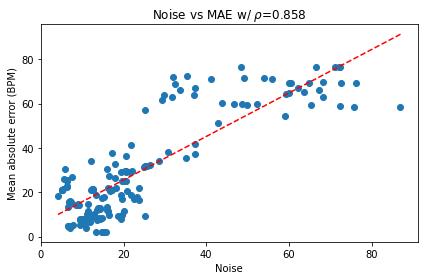

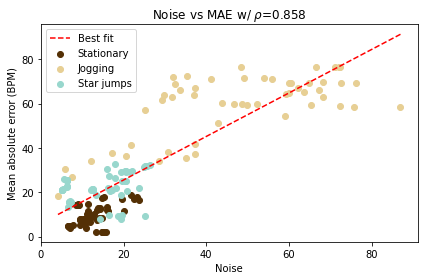

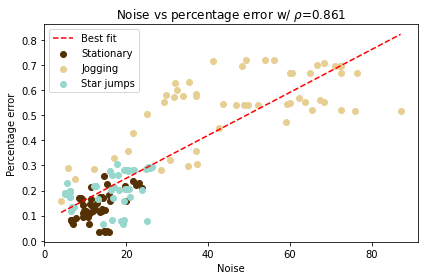

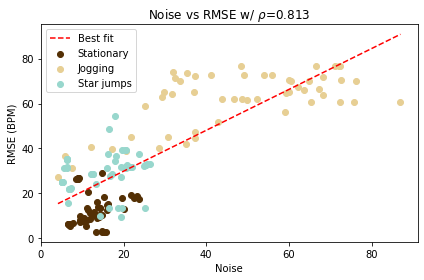

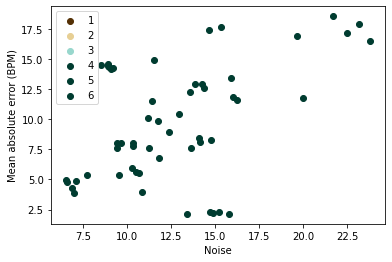

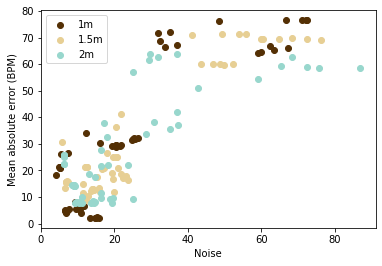

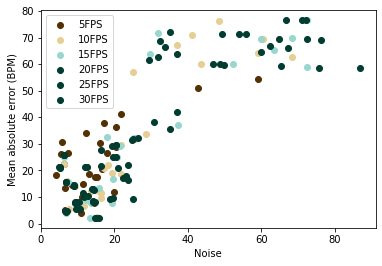

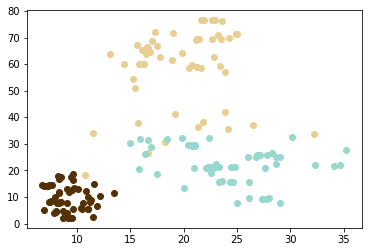

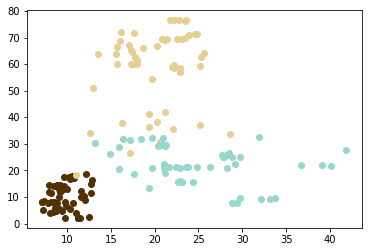

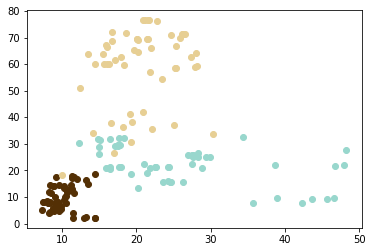

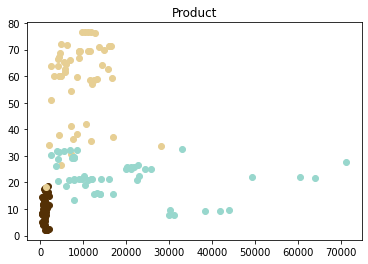

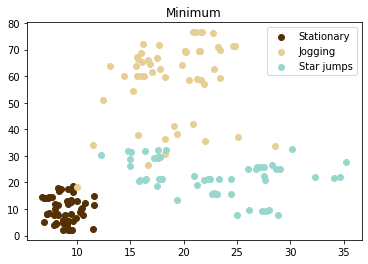

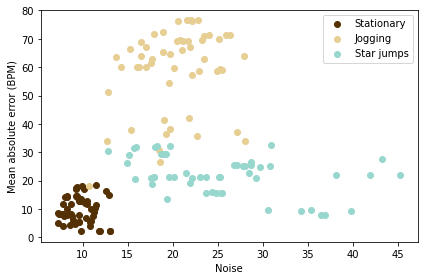

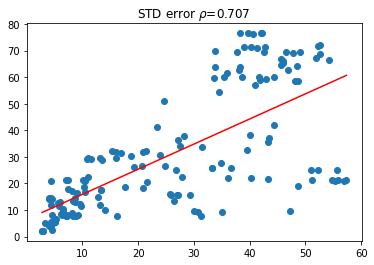

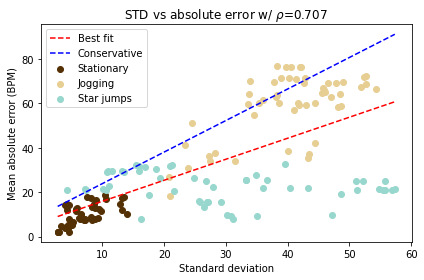

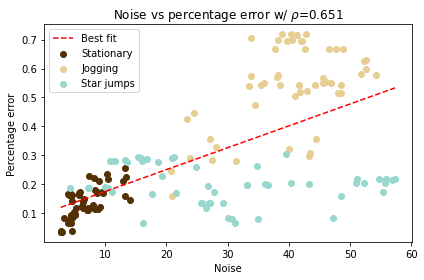

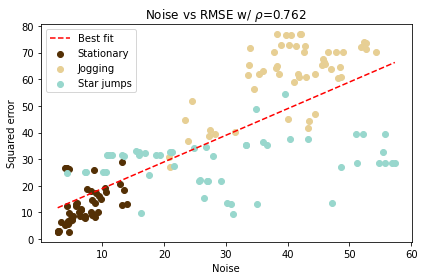

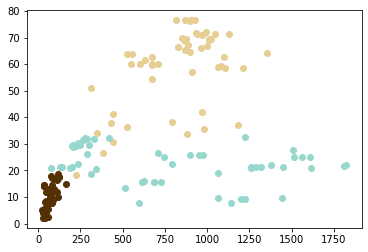

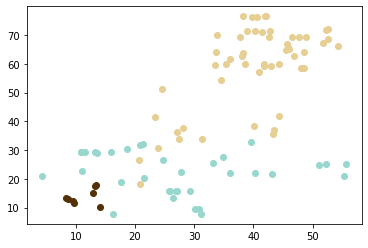

In [750]:
import matplotlib.cm as cm
distances = [1, 1.5, 2]
size = (6,4)
# cut = data[data["Framerate"]==30]
gender_cats = ["Male", "Female"]
skin_tone_cats = np.arange(1,7)
grouped = data.groupby(by=["Video", "Framerate"]).agg(np.mean)
s_grouped = stat_data.groupby(by=["Video", "Framerate"]).agg(np.mean)
# display(grouped)
videos = [grouped.index[i][0] for i in range(len(grouped.index))]
s_videos = [s_grouped.index[i][0] for i in range(len(s_grouped.index))]
grouped["Type"] = ["Stationary" if "stat" in s else "Jogging" if "jog" in s else "Star jumps" for s in videos]
grouped["Distance"] = [1 if "1_" in s else 1.5 if "1.5_" in s else 2 for s in videos]
cmap = cm.get_cmap("BrBG")
framerates = data["Framerate"].unique()
fig, ax = plt.subplots(figsize=(6,4))
x,y = grouped["Noise"]**-1, grouped["Error"]
r,p = pearsonr(x,y)
ax.scatter(x,y)
ax.set_xlabel("Noise")
ax.set_ylabel("Mean absolute error (BPM)")
ax.plot(np.unique(x), np.poly1d(np.polyfit(x, y, 1))(np.unique(x)), color="r", ls="--")
ax.title.set_text(fr"Noise vs MAE w/ $\rho$={round(r,3)}")
plt.tight_layout()
plt.savefig(eval_path+"Noise.pgf")

fig, ax = plt.subplots(figsize=size)
for i,t in enumerate(types):
    rel = grouped[(grouped["Type"]==t)]
    ax.scatter(rel["Noise"]**-1, rel["Error"], label=f"{t}", color=cmap(i/3))
ax.set_xlabel("Noise")
ax.plot(np.unique(x), np.poly1d(np.polyfit(x, y, 1))(np.unique(x)), color="r", label="Best fit", ls="--")
ax.set_ylabel("Mean absolute error (BPM)")
ax.title.set_text(fr"Noise vs MAE w/ $\rho$={round(r,3)}")
ax.legend()
plt.tight_layout()
plt.savefig(eval_path+"Noise-with-exer.pgf")

fig, ax = plt.subplots(figsize=size)

x,y = grouped["Noise"]**-1, grouped["P Error"]
r,p = pearsonr(x,y)
for i,t in enumerate(types):
    rel = grouped[(grouped["Type"]==t)]
    ax.scatter(rel["Noise"]**-1, rel["P Error"], label=f"{t}", color=cmap(i/3))
ax.set_xlabel("Noise")
ax.plot(np.unique(x), np.poly1d(np.polyfit(x, y, 1))(np.unique(x)), color="r", label="Best fit", ls="--")
ax.set_ylabel("Percentage error")
ax.title.set_text(fr"Noise vs percentage error w/ $\rho$={round(r,3)}")
ax.legend()
plt.tight_layout()
plt.savefig(eval_path+"Noise-with-exer-perc.pgf")

fig, ax = plt.subplots(figsize=size)
x,y = grouped["Noise"]**-1, np.sqrt(grouped["RMSE"])
r,p = pearsonr(x,y)
for i,t in enumerate(types):
    rel = grouped[(grouped["Type"]==t)]
    ax.scatter(rel["Noise"]**-1, np.sqrt(rel["RMSE"]), label=f"{t}", color=cmap(i/3))
ax.set_xlabel("Noise")
ax.plot(np.unique(x), np.poly1d(np.polyfit(x, y, 1))(np.unique(x)), color="r", label="Best fit", ls="--")
ax.set_ylabel("RMSE (BPM)")
ax.title.set_text(fr"Noise vs RMSE w/ $\rho$={round(r,3)}")
ax.legend()
plt.tight_layout()
plt.savefig(eval_path+"Noise-with-exer-squared.pgf")

fig, ax = plt.subplots(figsize=size)
for i,g in enumerate(skin_tone_cats):
    s_grouped["Skin tone"] = [skin_tones[cand(v)] for v in s_videos]
    rel = s_grouped[(s_grouped["Skin tone"]==g)]
    ax.scatter(rel["Noise"]**-1, rel["Error"], label=f"{g}", color=cmap(i/3))
ax.set_xlabel("Noise")
ax.set_ylabel("Mean absolute error (BPM)")
ax.legend()

fig, ax = plt.subplots(figsize=size)
for i,d in enumerate(distances):
    rel = grouped[(grouped["Distance"]==d)]
    ax.scatter(rel["Noise"]**-1, rel["Error"], label=f"{d}m", color=cmap(i/3))
ax.set_xlabel("Noise")
ax.set_ylabel("Mean absolute error (BPM)")
ax.legend()

fig, ax = plt.subplots(figsize=size)
for i,f in enumerate(framerates):
    rel = grouped.xs(f, level=1, drop_level=False)
    ax.scatter(rel["Noise"]**-1, rel["Error"], label=f"{f}FPS", color=cmap(i/3))
ax.set_xlabel("Noise")
ax.set_ylabel("Mean absolute error (BPM)")
ax.legend()
    
for ind in range(1,4):
    fig, ax = plt.subplots(figsize=size)
    for i,t in enumerate(types):
        rel = grouped[(grouped["Type"]==t)]
        ax.scatter(rel[f"SelfD Noise {ind}"]**-1, rel["Error"], label=f"{t}", color=cmap(i/3))
print(pearsonr(grouped["SelfNoise"]**-1, grouped["Error"]))

fig, ax = plt.subplots(figsize=size)
for i,t in enumerate(types):
    rel = grouped[(grouped["Type"]==t)]
    ax.scatter((rel[f"SelfD Noise 1"] * rel[f"SelfD Noise 2"] * rel[f"SelfD Noise 3"])**-1, rel["Error"], label=f"{t}", color=cmap(i/3))
ax.title.set_text("Product")
    
fig, ax = plt.subplots(figsize=size)
for i,t in enumerate(types):
    rel = grouped[(grouped["Type"]==t)]
    x = np.maximum(rel[f"SelfD Noise 1"], np.maximum(rel[f"SelfD Noise 2"], rel[f"SelfD Noise 3"]))
    ax.scatter(x**-1, rel["Error"], label=f"{t}", color=cmap(i/3))
ax.title.set_text("Minimum")
ax.legend()
    
fig, ax = plt.subplots(figsize=size)
for i,t in enumerate(types):
    rel = grouped[(grouped["Type"]==t)]
    ax.scatter(rel[f"SelfNoise"]**-1, rel["Error"], label=f"{t}", color=cmap(i/3))
ax.set_xlabel("Noise")
ax.set_ylabel("Mean absolute error (BPM)")
plt.tight_layout()
ax.legend()

fig, ax = plt.subplots(figsize=size)
x,y = grouped["SelfNoiseStd"], grouped["Error"]
ax.scatter(x,y)
ax.plot(np.unique(x), np.poly1d(np.polyfit(x, y, 1))(np.unique(x)), color="r")
r_val, p = pearsonr(grouped["SelfNoiseStd"], grouped["Error"])
ax.title.set_text(fr"STD error $\rho$={round(r_val, 3)}")

fig, ax = plt.subplots(figsize=size)
for i,t in enumerate(types):
    rel = grouped[(grouped["Type"]==t)]
    ax.scatter(rel[f"SelfNoiseStd"], rel["Error"], label=f"{t}", color=cmap(i/3))
ax.title.set_text(fr"STD vs absolute error w/ $\rho$={round(r_val, 3)}")
ax.set_xlabel("Standard deviation")
ax.set_ylabel("Mean absolute error (BPM)")
ax.plot(np.unique(x), np.poly1d(np.polyfit(x, y, 1))(np.unique(x)), color="r", ls="--", label="Best fit")
ax.plot(np.unique(x), 1.5*np.poly1d(np.polyfit(x, y, 1))(np.unique(x)), color="b", ls="--", label="Conservative")
ax.legend()
plt.tight_layout()
plt.savefig(eval_path+"std_error.pgf")

fig, ax = plt.subplots(figsize=size)
x,y = grouped["SelfNoiseStd"], grouped["P Error"]
r,p = pearsonr(x,y)
for i,t in enumerate(types):
    rel = grouped[(grouped["Type"]==t)]
    ax.scatter(rel["SelfNoiseStd"], rel["P Error"], label=f"{t}", color=cmap(i/3))
ax.set_xlabel("Noise")
ax.plot(np.unique(x), np.poly1d(np.polyfit(x, y, 1))(np.unique(x)), color="r", label="Best fit", ls="--")
ax.set_ylabel("Percentage error")
ax.title.set_text(fr"Noise vs percentage error w/ $\rho$={round(r,3)}")
ax.legend()
plt.tight_layout()
plt.savefig(eval_path+"std_perc.pgf")

fig, ax = plt.subplots(figsize=size)
x,y = grouped["SelfNoiseStd"], np.sqrt(grouped["RMSE"])
r,p = pearsonr(x,y)
for i,t in enumerate(types):
    rel = grouped[(grouped["Type"]==t)]
    ax.scatter(rel["SelfNoiseStd"], np.sqrt(rel["RMSE"]), label=f"{t}", color=cmap(i/3))
ax.set_xlabel("Noise")
ax.plot(np.unique(x), np.poly1d(np.polyfit(x, y, 1))(np.unique(x)), color="r", label="Best fit", ls="--")
ax.set_ylabel("Squared error")
ax.title.set_text(fr"Noise vs RMSE w/ $\rho$={round(r,3)}")
ax.legend()
plt.tight_layout()
plt.savefig(eval_path+"std_rmse.pgf")

fig, ax = plt.subplots(figsize=size)
for i,t in enumerate(types):
    rel = grouped[(grouped["Type"]==t)]
    ax.scatter(rel[f"SelfNoiseStd"]* (rel["SelfNoise"]**-1), rel["Error"], label=f"{t}", color=cmap(i/3))
    
fig, ax = plt.subplots(figsize=size)
ind = grouped["rPPG HR MV"] != grouped["rPPG HR ICA"]
cropped = grouped.loc[ind]
for i,t in enumerate(types):
    rel = cropped[(cropped["Type"]==t)]
    ax.scatter(rel["SelfNoiseStd"], rel["Error"], label=f"{t}", color=cmap(i/3))

In [118]:
pd.set_option('display.max_rows', 432)
pd.set_option('display.max_columns', 200)
display(grouped[["Noise 1", "Error"]])

Noise 1  \
Video                                              Framerate             
/home/yousuf/workspace/dissertation/code/rPPG/e... 5.0        0.951940   
                                                   10.0       0.979810   
                                                   15.0       0.979581   
                                                   20.0       0.980443   
                                                   25.0       0.980725   
                                                   30.0       0.980784   
/home/yousuf/workspace/dissertation/code/rPPG/e... 5.0        0.930569   
                                                   10.0       0.964639   
                                                   15.0       0.969413   
                                                   20.0       0.970522   
                                                   25.0       0.971257   
                                                   30.0       0.972484   
/home/yousuf/workspace/dissertation/code/rPPG/e... 5.0        0.835212   
                                                   10.0       0.963851   
                                                   15.0       0.969861   
                                                   20.0       0.968037   
                                                   25.0       0.968846   
                                                   30.0       0.969411   
/home/yousuf/workspace/dissertation/code/rPPG/e... 5.0        0.596511   
                                                   10.0       0.624918   
                                                   15.0       0.611002   
                                                   20.0       0.614396   
                                                   25.0       0.612867   
                                                   30.0       0.613975   
/home/yousuf/workspace/dissertation/code/rPPG/e... 5.0        0.711180   
                                                   10.0       0.718958   
                                                   15.0       0.719573   
                                                   20.0       0.713024   
                                                   25.0       0.716300   
                                                   30.0       0.717668   
/home/yousuf/workspace/dissertation/code/rPPG/e... 5.0        0.504450   
                                                   10.0       0.524182   
                                                   15.0       0.510253   
                                                   20.0       0.498648   
                                                   25.0       0.493926   
                                                   30.0       0.493511   
/home/yousuf/workspace/dissertation/code/rPPG/e... 5.0        0.835165   
                                                   10.0       0.848207   
                                                   15.0       0.847813   
                                                   20.0       0.846588   
                                                   25.0       0.847877   
                                                   30.0       0.848125   
/home/yousuf/workspace/dissertation/code/rPPG/e... 5.0        0.864958   
                                                   10.0       0.904963   
                                                   15.0       0.905104   
                                                   20.0       0.907728   
                                                   25.0       0.908950   
                                                   30.0       0.910752   
/home/yousuf/workspace/dissertation/code/rPPG/e... 5.0        0.902960   
                                                   10.0       0.908296   
                                                   15.0       0.898685   
                                                   20.0       0.898891   
                                                   25.0       0.897

In [295]:
grouped.loc[np.isinf(grouped["Noise"]), "Noise"] = 400

In [300]:
from scipy.stats import pearsonr
# pearsonr(cut["Noise"], cut["Error"])
print(pearsonr(grouped["Noise"]**-1, grouped["Error"]))
print(pearsonr(grouped["SelfNoise"]**-1, grouped["Error"]))

(0.8269836885440474, 7.348718010303607e-42)
(0.41070073520751177, 5.688482216653768e-08)


In [314]:
framerate = data.groupby("Framerate").agg(np.mean)
display(framerate["Error"])

Framerate
5     23.448058
10    31.369230
15    31.669345
20    31.691318
25    31.651767
30    31.596692
Name: Error, dtype: float64

# Effect of gender and skin tone

In [516]:
skin_types = {
    1042: ["Male", 2], # asian
    1172: ["Male", 2], # asian
#     1302: ["Female", 2], # asian
    132: ["Male", 3],
    1562: ["Male", 3],
#     1692: ["Female", 3],
    1952: ["Male", 3], # blue cap
    2: ["Male", 2],
    2082: ["Male", 5],
    2212: ["Male", 3],
    2342: ["Female", 3],
#     2472: ["Female", 4],
    2602: ["Female", 2], #asian
    262: ["Male", 5], #asian
    2732: ["Female", 2],
    2862: ["Female", 4],
    2992: ["Female", 2],
#     3122: ["Female", 3],
    3382: ["Male", 3],
#     3512: ["Female", 3],
    3642: ["Female", 1],
    3772: ["Male", 1],
    3642: ["Female", 3],
    524: ["Female", 4],
    652: ["Female", 4],
    782: ["Female", 2], # asian
    912: ["Male", 2],
    0: ["Male", 6] # me
}

In [517]:
candidates = skin_types.keys()
genders = {}
skin_tones = {}
for k in skin_types.keys():
    genders[k] = skin_types[k][0]
    skin_tones[k] = skin_types[k][1]

In [706]:
data = pd.read_csv("/Users/yousuf/Workspace/dissertation/code/rPPG/output/hr_evaluation/sp-fixed-bpm-trilogy.csv")
print(data.columns)
to_drop = ['1302', '1692', '2472', '2732', '3122', '3512']
ind = ["BayesianSkinDetector-weighted" in s for s in data["Region selector"]]
data = data.loc[ind]
ind = [not(any([d in s for d in to_drop])) for s in data['Video']]
data = data.loc[ind]
def cand(vid):
    for c in candidates:
        if f"/{c}/" in vid:
            return c
    return 0
data["Candidate"] = [cand(v) for v in data["Video"]]
data["Gender"] = [genders[cand(v)] for v in data["Video"]]
data["Skin type"] = [skin_tones[cand(v)] for v in data["Video"]]
data["Error"] = np.abs(data["rPPG HR MV"]-data["ECG HR BC"])
data = data.loc[(data["Candidate"] != 0) | ((data["Candidate"] == 0) & (["stat" in v for v in data["Video"]]))]

Index(['Video', 'Tracker', 'Region selector', 'Window size', 'Offset size',
       'Heart Rate Number', 'rPPG HR ICA', 'rPPG HR MV', 'rPPG HR PCA',
       'PPG HR BC', 'PPG HR FFT', 'ECG HR BC', 'ECG HR FFT', 'ICA 1 HR',
       'ICA 1 Power', 'ICA 1 BC', 'ICA 2 HR', 'ICA 2 Power', 'ICA 2 BC',
       'ICA 3 HR', 'ICA 3 Power', 'ICA 3 BC', 'PCA 1 HR', 'PCA 1 Power',
       'PCA 1 BC', 'PCA 2 HR', 'PCA 2 Power', 'PCA 2 BC', 'PCA 3 HR',
       'PCA 3 Power', 'PCA 3 BC', 'R HR', 'R Power', 'R BC', 'G HR', 'G Power',
       'G BC', 'B HR', 'B Power', 'B BC'],
      dtype='object')


In [707]:
grouped = data.groupby("Skin type").agg({"Error":[np.mean, np.std]})
grouped

Error           
                mean        std
Skin type                      
1          14.074039  13.628259
2          19.890715  16.542764
3          21.920069  15.621824
4          15.007908  14.312746
5          20.519733  16.449859
6           8.077672  10.082003

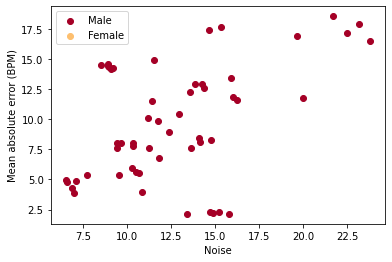

In [708]:
fig, ax = plt.subplots(figsize=size)
for i,g in enumerate(gender_cats):
    s_grouped["Gender"] = [genders[cand(v)] for v in s_videos]
    rel = s_grouped[(s_grouped["Gender"]==g)]
    ax.scatter(rel["Noise"]**-1, rel["Error"], label=f"{g}", color=cmap(i/3))
ax.set_xlabel("Noise")
ax.set_ylabel("Mean absolute error (BPM)")
ax.legend()

2652
2652


,mean,std
Gender,,
Female,16.274721,13.486644
Male,20.400735,17.047984


16.274721385968917
20.400735184721984
1040
1612
Errors
[12.228564542292148, 14.650841630732877, 15.320048564812325, 18.418082616166455, 21.808076844697418, 11.612400862931224, 18.61721213353588, 18.792795134020167]
[25.226212119274876, 32.57078025964323, 21.475644944422235, 27.08143956284955, 12.060724462075287, 14.619940509681596, 15.814060267428822, 32.857642738506016, 23.187119296545227, 33.557741139786714, 14.07403930363828, 20.47267030610426, 8.077672347977206]


Ttest_indResult(statistic=-1.9578574029330367, pvalue=0.06642950056866782)

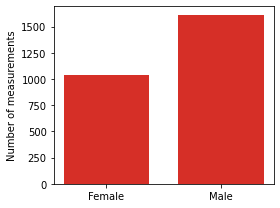

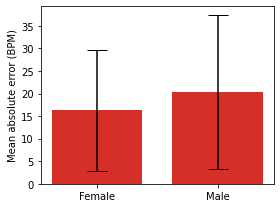

In [720]:
fig, ax =  plt.subplots(figsize=(4,3))
c = [0.4,0.8]
g = genders.values()
# cropped = data.loc[data["Candidate"]!=0]
cropped = data
er_f, er_m = cropped.loc[cropped["Gender"]=="Female", "Error"], cropped.loc[cropped["Gender"]=="Male", "Error"]
ax.bar(c[0], len(er_f), width=0.3, color=cmap(0.1))
ax.bar(c[1], len(er_m), width=0.3, color=cmap(0.1))
ax.set_xticks(c)
ax.set_xticklabels(["Female", "Male"])
ax.set_ylabel("Number of measurements")
plt.tight_layout()
plt.savefig(eval_path+"gender_freq.pgf")
from scipy.stats import ttest_ind
fig, ax = plt.subplots(figsize=(4,3))
print(len(data))
print(len(cropped))
grouped = cropped.groupby("Gender").agg({"Error":[np.mean, np.std]})
grouped.columns = ["mean", "std"]
display(grouped)
f,m = grouped.loc["Female"], grouped.loc["Male"]
cmap = cm.get_cmap("RdYlGn")
c = [0.4,0.8]
ax.bar(c[0], f["mean"], yerr=f["std"], capsize=10, width=0.3, color=cmap(0.1))
ax.bar(c[1], m["mean"], yerr=m["std"], capsize=10, width=0.3, color=cmap(0.1))
ax.set_xticks(c)
ax.set_xticklabels(["Female", "Male"])
ax.set_ylabel("Mean absolute error (BPM)")
plt.tight_layout()
plt.savefig(eval_path+"gender_error.pgf")
print(np.mean(er_f))
print(np.mean(er_m))
print(len(er_f))
print(len(er_m))
ttest_ind(er_f, er_m, equal_var=False)


er_f = []
er_m = []
for cand in skin_types.keys():
    errs = np.mean(cropped.loc[cropped["Candidate"]==cand, "Error"])
    if not(np.isnan(errs)):
        if skin_types[cand][0]=="Female":
            er_f.append(errs)
        else:
            er_m.append(errs)
print("Errors")
print(er_f)
print(er_m)
ttest_ind(er_f, er_m, equal_var=False)
# er_f = [cropped.loc[]]

# data["Gender"] == genders[]
# grouped
# plt.hist(data["Gender"], rwidth=0.1)

2652
2652
\begin{tabular}{lrr}
\toprule
{} &       mean &        std \\
Skin type &            &            \\
\midrule
1         &  14.074039 &  13.628259 \\
2         &  19.890715 &  16.542764 \\
3         &  21.920069 &  15.621824 \\
4         &  15.007908 &  14.312746 \\
5         &  20.519733 &  16.449859 \\
6         &   8.077672 &  10.082003 \\
\bottomrule
\end{tabular}

16.274721385968917
22.027656401932674
1040
1424
1,2,3,4,5
,3.555e-05,2.949e-08,0.5149,5.245e-05,4.655e-05,
,,0.0106,1.757e-07,0.5768,2.976e-31,
,,,2.959e-14,0.2031,6.745e-42,
,,,,5.296e-06,4.221e-11,
,,,,,1.542e-22,
,,,,,,


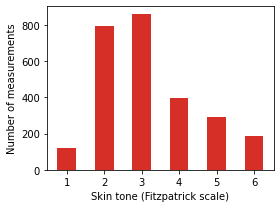

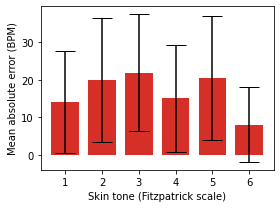

In [692]:
from scipy.stats import ttest_ind
fig, ax =  plt.subplots(figsize=(4,3))
# cropped = data.loc[data["Candidate"]!=0]
cropped = data
skin_tone_cats = np.arange(1,7)
c = np.arange(0.4, len(skin_tone_cats)*0.4, 0.4)
for ind, s in enumerate(skin_tone_cats): 
    er =  cropped.loc[cropped["Skin type"]==s, "Error"]
    ax.bar(c[ind], len(er), width=0.2, color=cmap(0.1))
# ax.bar(c[1], len(er_m), width=0.2, color=cmap(0.8))
ax.set_xticks(c)
ax.set_xticklabels(skin_tone_cats)
ax.set_ylabel("Number of measurements")
ax.set_xlabel("Skin tone (Fitzpatrick scale)")
plt.tight_layout()
plt.savefig(eval_path+"skin_tone.pgf")

fig, ax = plt.subplots(figsize=(4,3))
print(len(data))
print(len(cropped))
grouped = cropped.groupby("Skin type").agg({"Error":[np.mean, np.std]})
grouped.columns = ["mean", "std"]
print(grouped.to_latex())
for ind, s in enumerate(skin_tone_cats):
    d = grouped.loc[s]
    ax.bar(c[ind], d["mean"], yerr=d["std"], capsize=10, width=0.3, color=cmap(0.1))
ax.set_xticks(c)
ax.set_xticklabels(skin_tone_cats)
ax.set_ylabel("Mean absolute error (BPM)")
ax.set_xlabel("Skin tone (Fitzpatrick scale)")
plt.tight_layout()
plt.savefig(eval_path+"skin_error.pgf")
print(np.mean(er_f))
print(np.mean(er_m))
print(len(er_f))
print(len(er_m))
# print(list(np.arange(1,6)).join(","))
print(",".join(["1","2","3","4","5"]))
for i, s1 in enumerate(skin_tone_cats):
    row = ""
    for j, s2 in enumerate(skin_tone_cats):
        er_1 =  cropped.loc[cropped["Skin type"]==s1, "Error"]
        er_2 =  cropped.loc[cropped["Skin type"]==s2, "Error"]
        tstat, p_val = ttest_ind(er_1, er_2, equal_var=False)
        val = f"{round(p_val,4)}" if p_val > 0.01 else f"{p_val:.3e}"
        if s2 > s1:
            row += f"{val},"
        else:
            row += ","
    print(row)

# data["Gender"] == genders[]
# grouped
# plt.hist(data["Gender"], rwidth=0.1)

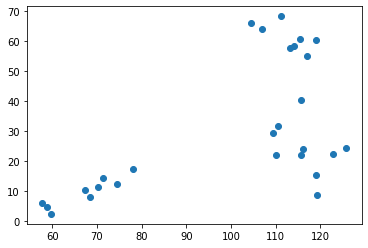

In [733]:
fig, ax = plt.subplots(figsize=(6,4))
grouped = data.groupby("Video").agg({"Error":np.mean, "ECG HR BC":np.mean})
grouped.columns = ["Err", "ECG"]
# display(grouped)
ax.scatter(grouped["ECG"], grouped["Err"])

# Impact of movement

3414
3414
\begin{tabular}{lrrrrrr}
\toprule
{} &       mean &        std &     pmean &      pstd &       hmean &       hstd \\
Type       &            &            &           &           &             &            \\
\midrule
Jogging    &  58.917110 &  21.160745 &  0.534726 &  0.226174 &  113.018702 &  11.446088 \\
Star jumps &  22.314003 &  20.510128 &  0.199543 &  0.188205 &  116.668361 &  13.051777 \\
Stationary &   9.747456 &  10.582271 &  0.135740 &  0.109795 &   67.353006 &  10.580703 \\
\bottomrule
\end{tabular}

Stationary: 67.35300620424277
Star jumps: 116.66836146714212
Jogging: 113.0187016561583
16.43100279114856
21.62120671214872
8
13
Stationary,Star jumps,Jogging
,1.740e-69,0.000e+00,
,,1.343e-285,
,,,


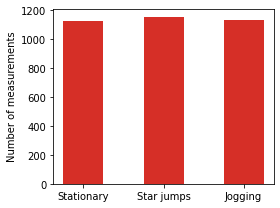

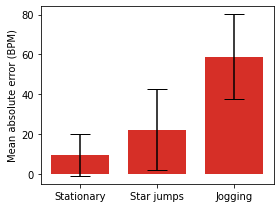

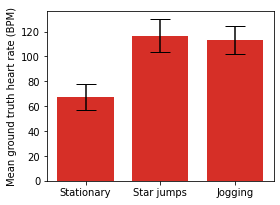

In [741]:
from scipy.stats import ttest_ind
fig, ax =  plt.subplots(figsize=(4,3))
cropped = data.loc[data["Candidate"]==0]
cropped["P Error"] = cropped["Error"]/cropped["ECG HR BC"]
mov_cats = ["Stationary", "Star jumps", "Jogging"]
cmap = cm.get_cmap("RdYlGn")
width = 0.4
c = np.arange(width, (len(mov_cats)*width), width)

for ind, s in enumerate(mov_cats): 
    er =  cropped.loc[cropped["Type"]==s, "Error"]
    ax.bar(c[ind], len(er), width=0.2, color=cmap(0.1))
# ax.bar(c[1], len(er_m), width=0.2, color=cmap(0.8))
ax.set_xticks(c)
ax.set_xticklabels(mov_cats)
ax.set_ylabel("Number of measurements")
# ax.set_xlabel("Skin tone (Fitzpatrick)")
plt.tight_layout()
plt.savefig(eval_path+"movement_freq.pgf")

fig, ax = plt.subplots(figsize=(4,3))
print(len(data))
print(len(cropped))
grouped = cropped.groupby("Type").agg({"Error":[np.mean, np.std], "P Error":[np.mean, np.std], "ECG HR BC":[np.mean, np.std]})
grouped.columns = ["mean", "std", "pmean", "pstd", "hmean", "hstd"]
print(grouped.to_latex())
for ind, s in enumerate(mov_cats):
    d = grouped.loc[s]
    print(f"{s}: {d['hmean']}")
    ax.bar(c[ind], d["mean"], yerr=d["std"], capsize=10, width=0.3, color=cmap(0.1))
ax.set_xticks(c)
ax.set_xticklabels(mov_cats)
ax.set_ylabel("Mean absolute error (BPM)")
# ax.set_xlabel("Skin tone (Fitzpatrick scale)")
plt.tight_layout()
plt.savefig(eval_path+"movement_error.pgf")
print(np.mean(er_f))
print(np.mean(er_m))
print(len(er_f))
print(len(er_m))
# print(list(np.arange(1,6)).join(","))
fig, ax = plt.subplots(figsize=(4,3))
for ind, s in enumerate(mov_cats):
    d = grouped.loc[s]
    ax.bar(c[ind], d["hmean"], yerr=d["hstd"], capsize=10, width=0.3, color=cmap(0.1))
ax.set_xticks(c)
ax.set_xticklabels(mov_cats)
ax.set_ylabel("Mean ground truth heart rate (BPM)")
# ax.set_xlabel("Skin tone (Fitzpatrick scale)")
plt.tight_layout()
plt.savefig(eval_path+"movement_perc_error.pgf")
print(",".join(mov_cats))
for i, s1 in enumerate(mov_cats):
    row = ""
    for j, s2 in enumerate(mov_cats):
        er_1 =  cropped.loc[cropped["Type"]==s1, "Error"]
        er_2 =  cropped.loc[cropped["Type"]==s2, "Error"]
        tstat, p_val = ttest_ind(er_1, er_2, equal_var=False)
        val = f"{round(p_val,4)}" if p_val > 0.01 else f"{p_val:.3e}"
#         val = p_val
        if j > i:
            row += f"{val},"
        else:
            row += ","
    print(row)

# data["Gender"] == genders[]
# grouped
# plt.hist(data["Gender"], rwidth=0.1)

# Impact of distance

3414
3414
\begin{tabular}{lrr}
\toprule
{} &       mean &        std \\
Distance &            &            \\
\midrule
1.0      &  31.714033 &  28.408462 \\
1.5      &  31.810625 &  27.123121 \\
2.0      &  27.380072 &  26.962228 \\
\bottomrule
\end{tabular}

14.727965057380928
15.879460569724928
5799
8473
1,1.5,2
,0.934,1.919e-04,
,,9.445e-05,
,,,


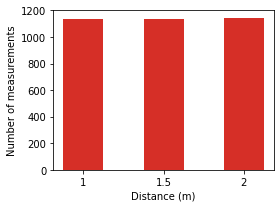

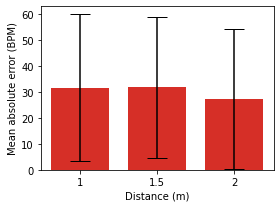

In [679]:
fig, ax =  plt.subplots(figsize=(4,3))
cropped = data.loc[data["Candidate"]==0]
dist_cats = [1, 1.5, 2]
cmap = cm.get_cmap("RdYlGn")
width = 0.4
c = np.arange(width, (len(dist_cats)*width), width)

for ind, s in enumerate(dist_cats): 
    er =  cropped.loc[cropped["Distance"]==s, "Error"]
    ax.bar(c[ind], len(er), width=0.2, color=cmap(0.1))
# ax.bar(c[1], len(er_m), width=0.2, color=cmap(0.8))
ax.set_xticks(c)
ax.set_xticklabels(dist_cats)
ax.set_ylabel("Number of measurements")
ax.set_xlabel("Distance (m)")
plt.tight_layout()
plt.savefig(eval_path+"dist_freq.pgf")

fig, ax = plt.subplots(figsize=(4,3))
print(len(data))
print(len(cropped))
grouped = cropped.groupby("Distance").agg({"Error":[np.mean, np.std]})
grouped.columns = ["mean", "std"]
print(grouped.to_latex())
for ind, s in enumerate(dist_cats):
    d = grouped.loc[s]
    ax.bar(c[ind], d["mean"], yerr=d["std"], capsize=10, width=0.3, color=cmap(0.1))
ax.set_xticks(c)
ax.set_xticklabels(dist_cats)
ax.set_ylabel("Mean absolute error (BPM)")
ax.set_xlabel("Distance (m)")
plt.tight_layout()
plt.savefig(eval_path+"dist_error.pgf")
print(np.mean(er_f))
print(np.mean(er_m))
print(len(er_f))
print(len(er_m))
# print(list(np.arange(1,6)).join(","))
# print(",".join(dist_cats))
print(",".join([str(i) for i in dist_cats]))
for i, s1 in enumerate(dist_cats):
    row = ""
    for j, s2 in enumerate(dist_cats):
        er_1 =  cropped.loc[cropped["Distance"]==s1, "Error"]
        er_2 =  cropped.loc[cropped["Distance"]==s2, "Error"]
        tstat, p_val = ttest_ind(er_1, er_2, equal_var=False)
        val = f"{round(p_val,4)}" if p_val > 0.01 else f"{p_val:.3e}"
#         val = p_val
        if j > i:
            row += f"{val},"
        else:
            row += ","
    print(row)

# data["Gender"] == genders[]
# grouped
# plt.hist(data["Gender"], rwidth=0.1)

# Quantifying noise

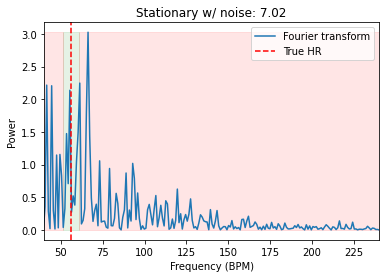

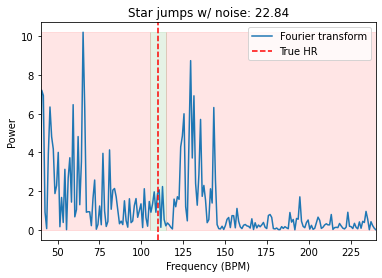

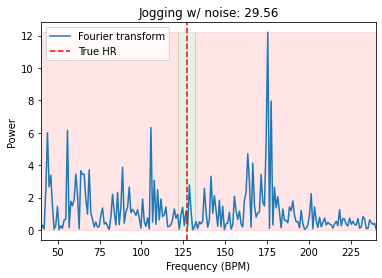

In [478]:
from matplotlib.patches import Rectangle
from sklearn.decomposition import FastICA
def ica(values):
    ica = FastICA(n_components=3, max_iter=40000)
    signals = ica.fit_transform(values)
    return signals

def noise(data, framerate, true_hr):
    if true_hr is None:
        return None

    data = (data-np.mean(data))/np.std(data)
    transform = np.fft.rfft(data)
    freqs = np.fft.rfftfreq(len(data), 1.0/framerate)
    freqs = 60*freqs
    delta = 4
    band_pass = np.where((freqs < 40) | (freqs > 240) )[0]
    transform[band_pass] = 0
    # hr_range = np.where((freqs > 40) & (freqs < 240) & (freqs > (true_hr + delta)) & (freqs < ((true_hr - delta))))[0]
    lower = (freqs > (true_hr + delta))
    upper = (freqs < (true_hr - delta))
    hr_range = np.where(lower | upper)[0]
    transform = np.abs(transform)**2
    noise_value = np.sum(transform[hr_range])
    # print(f"Noise value {noise_value}")
    # print(f"{np.sum(transform[~hr_range])}")
    numerator = np.sum(transform)-np.sum(transform[hr_range])
    return numerator/np.sum(transform)
stat = "/Users/yousuf/Workspace/dissertation/code/rPPG/output/hr_evaluation/1_stat_1-RepeatedDetector-DNNDetector-PrimitiveROI-fixed.csv"
star = "/Users/yousuf/Workspace/dissertation/code/rPPG/output/hr_evaluation/1_star_1-RepeatedDetector-DNNDetector-PrimitiveROI-fixed.csv"
jog = "/Users/yousuf/Workspace/dissertation/code/rPPG/output/hr_evaluation/1_jog_1-KLTBoxingWithThresholding-DNNDetector-PrimitiveROI-fixed.csv"

stat = np.loadtxt(stat)
star = np.loadtxt(star)
jog = np.loadtxt(jog)
true_hrs = [56, 110, 127]
component = 2
titles = ["Stationary", "Star jumps", "Jogging"]
for i,d in enumerate([stat, star, jog]):
    fig, ax = plt.subplots(figsize=(6,4))
    ica_res = ica(d)
    component = np.argmax([np.max(ica_res[:, i]) for i in range(3)])
    signal = ica_res[:, component]
    f, t = fft(signal, 30)
    true_hr = true_hrs[i]
    ax.plot(f,t, label="Fourier transform")
    ax.set_xlim(40,240)
    delta = 5
    ax.axvline(true_hr, ls='--', color="r", label="True HR")
    ax.add_patch(Rectangle((true_hr-delta,0),2*delta,np.max(t), alpha=0.1, color="g"))
    ax.add_patch(Rectangle((40,0),true_hr-delta-40,np.max(t), alpha=0.1, color="r"))
    ax.add_patch(Rectangle((true_hr+delta,0),240-true_hr+delta,np.max(t), alpha=0.1, color="r"))
    ax.set_xlabel("Frequency (BPM)")
    ax.set_ylabel("Power")
    ax.title.set_text(f"{titles[i]} w/ noise: {round(noise(signal, 30, true_hr)**-1, 2)}")
    ax.legend()
    plt.savefig(eval_path+f"Noise{titles[i]}.pgf")

# Effect of framerate

In [487]:
data.groupby("Framerate").agg({"Error":[np.mean, np.std]})

Error           
                mean        std
Framerate                      
5          24.657748  21.112726
10         27.753797  24.942705
15         27.678530  25.295243
20         28.513365  25.500977
25         28.161904  25.319304
30         28.342677  25.456996